In [1]:
import numpy as np

###MSE

In [2]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    #print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

### Fit fuction

In [3]:
from typing import Callable

def fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    if epoch % 20 == 0:
      print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

### Two dimention data

####Linear model

In [4]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

#### Two dimention linear input

(100, 2) (2, 1) (1,)
x: (100, 2), weights: (2, 1), bias: (1,), y: (100, 1)


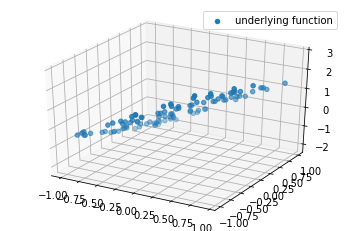

In [5]:
# What about 2-dimensional x?

n = 100
d = 2
x = np.random.uniform(-1, 1, (n, d))

# y = w * x + b
# y = w_0 * x_0 + w_1 * x_1 + w_2 * x_2 + b
# y = w@x + b

weights_true = np.array([[2, -1], ]).T
bias_true = np.array([0.5])
print(x.shape, weights_true.shape, bias_true.shape)

y_true = x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

plot_3d(x, y_true)

####Initialize linear and loss for two dimention data

2.9185546101746787


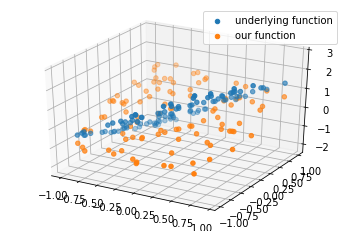

In [6]:
loss = MSE()
linear = Linear(2)
y_pred = linear(x)
print(loss(y_pred, y_true))
fig = plot_3d(x, y_true, y_pred)

####Train two dimention data

Epoch 0, loss 2.9185546101746787


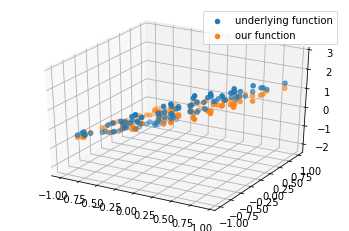

In [7]:
fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=20)
plot_3d(x, y_true, linear(x))

###Three dimention data

#### Non-Linear model

In [8]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = np.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      # import pdb; pdb.set_trace()  # By the way, this is how you can debug
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

class Model:
  def __init__(self, input_dim, num_hidden, ouput_dim):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.relu2 = Relu()
    self.linear2 = Linear(num_hidden, ouput_dim)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    r2 = self.relu2(r1)
    l2 = self.linear2(r2)
    return l2
  
  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear2_gradient)
    relu1_gradient = self.relu1.backward(relu2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

####Three dimention non-linear input

x: (200, 3), weights: (3, 2), bias: (2,), y: (200, 2)


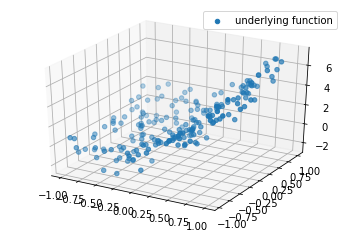

In [9]:
n = 200
d = 3
x = np.random.uniform(-1, 1, (n, d))

weights_true = np.array([[3, 1, -1],[2, 0, -2],]).T
bias_true = np.array([0.5, 0.1])

y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

plot_3d(x, y_true[:, 0])

####Initialize linear and loss for three dimention data

(200, 3) (3, 2) (200, 2) (200, 2)
5.4464521890696025


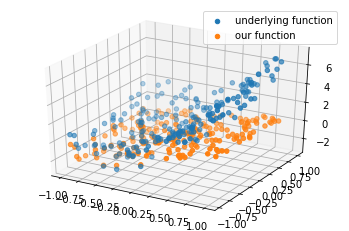

In [10]:
loss = MSE()
# 3-d input and 2-d output with 2 hidden layers
nonlinear = Model(3, 10, 2)
y_pred = nonlinear(x)
print(x.shape, weights_true.shape, y_true.shape, y_pred.shape)
print(loss(y_pred, y_true))
fig = plot_3d(x, y_true[:, 0], y_pred[:, 0])

####Train three dimention data

Epoch 0, loss 0.039051229223341276
Epoch 20, loss 0.03803359483132387
Epoch 40, loss 0.037078865938890676
Epoch 60, loss 0.03623664011949435
Epoch 80, loss 0.03554868792533755
Epoch 100, loss 0.03494517037498858
Epoch 120, loss 0.034337323909363685
Epoch 140, loss 0.033707591648561366
Epoch 160, loss 0.03313676211627266
Epoch 180, loss 0.03262487860250926


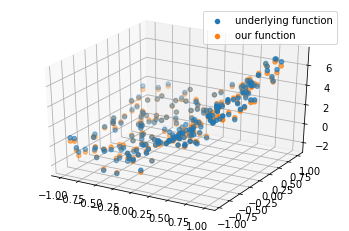

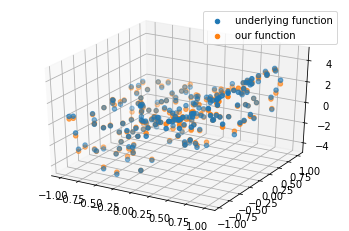

In [14]:
fit(x, y_true, model=nonlinear, loss=loss, lr=0.1, num_epochs=200)
#plot_3d(x, y_true, nonlinear(x))
y_pred = nonlinear(x)
fig = plot_3d(x, y_true[:, 0], y_pred[:, 0])
fig = plot_3d(x, y_true[:, 1], y_pred[:, 1])

####Plot the output and the real data using tsne

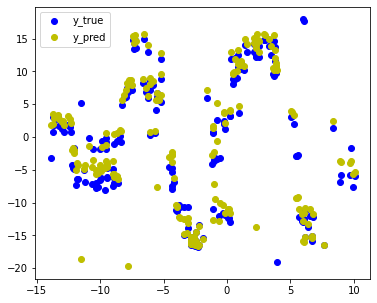

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=1, random_state=0)

x_2d = tsne.fit_transform(x)
yt_2d = tsne.fit_transform(y_true)
yp_2d = tsne.fit_transform(y_pred)

#target_ids = range(len(digits.target_names))

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))

plt.scatter(x_2d[:, 0], yt_2d[:, 0], c='b', label='y_true')
plt.scatter(x_2d[:, 0], yp_2d[:, 0], c='y', label='y_pred')
plt.legend()
plt.show()